In [1]:
# Imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error 

from sklearn.linear_model import LinearRegression, Lasso

from xgboost import XGBRegressor

from scipy.stats import randint, uniform

# Spotify Popularity Predictor (39%)

The goal of this challenge is to create a model that predicts the popularity of a song based on its features.

The dataset contains a list of tracks with the following characteristics:
- `acousticness`: whether the track is acoustic
- `danceability`: describes how suitable a track is for dancing
- `duration_ms`: duration of the track in milliseconds
- `energy`: represents a perceptual measure of intensity and activity
- `explicit`: whether the track has explicit lyrics
- `id`: id for the track
- `instrumentalness`: predicts whether a track contains no vocals
- `key`: the key the track is in
- `liveness`: detects the presence of an audience in the recording
- `loudness`: the overall loudness of a track in decibels
- `mode`: modality of a track
- `name`: name of the track
- `popularity`: popularity of the track
- `release_date`: release date
- `speechiness`: detects the presence of spoken words in a track
- `tempo`: overall estimated tempo of a track in beats per minute
- `valence`: describes the musical positiveness conveyed by a track
- `artist`: artist who performed the track

# Model

## Data collection

**📝 Load the `spotify_popularity_train.csv` dataset from the provided URL. Display the first few rows. Perform the usual cleaning operations. Store the result in a `DataFrame` named `data`.**

👉 Do not forget to clean the dataset

In [2]:
url = "https://wagon-public-datasets.s3.amazonaws.com/certification_paris_2021Q1/spotify_popularity_train.csv"

In [3]:
data = pd.read_csv(url)
data.head(3)

,acousticness,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,artist
0,0.65400,0.499,219827,0.190,0,0B6BeEUd6UwFlbsHMQKjob,0.00409,7,0.0898,-16.435,1,Back in the Goodle Days,40,1971,0.0454,149.460,0.4300,John Hartford
1,0.00592,0.439,483948,0.808,0,5Gpx4lJy3vKmIvjwbiR5c8,0.14000,2,0.0890,-8.497,1,Worlds Which Break Us - Intro Mix,22,2015-02-02,0.0677,138.040,0.0587,Driftmoon
2,0.73400,0.523,245693,0.288,0,7MxuUYqrCIy93h1EEHrIrL,0.00000,0,0.0771,-11.506,1,I'm The Greatest Star,40,1968-09-01,0.2140,75.869,0.4640,Barbra Streisand


Let us have a look at potentially missing values. 

In [4]:
data.isnull().sum()

acousticness        0
danceability        0
duration_ms         0
energy              0
explicit            0
id                  0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
name                0
popularity          0
release_date        0
speechiness         0
tempo               0
valence             0
artist              4
dtype: int64

It seems that 4 songs do not display any artist. 

In [5]:
data[data['artist'].isnull()]

,acousticness,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,artist
12850,0.517,0.613,191867,0.549,0,3NWCbI2VtW80g8cZG3QHIx,0.4440,7,0.0412,-7.648,1,easy going,0,1935,0.0327,83.967,0.583,NaN
17924,0.732,0.535,279600,0.435,0,0cSyeb33PyBMtLeUzCgDgO,0.2530,4,0.1190,-9.021,0,concerto piccolo,0,1935,0.0303,106.124,0.205,NaN
22383,0.758,0.376,189560,0.332,0,3gWhV34vWEBwguH0RP2w7j,0.0482,3,0.0766,-8.420,1,comfort ye my people,0,1935,0.0296,91.840,0.260,NaN
32011,0.981,0.492,236733,0.286,0,2nUaz5sLG0HccdACC1IG35,0.8920,3,0.1430,-8.966,1,i know that my redeemer liveth,0,1935,0.0336,87.973,0.273,NaN


This can be put in relation with the overall number of observations in the dataset:

In [6]:
data.shape

(52317, 18)

Since `artist` is likely to be a variable of close interest in our modelling task and it cannot really be imputed, we are going to drop these 4 lines.

In [7]:
data.dropna(inplace=True)

Let us now check data types.

In [8]:
data.dtypes

acousticness        float64
danceability        float64
duration_ms           int64
energy              float64
explicit              int64
id                   object
instrumentalness    float64
key                   int64
liveness            float64
loudness            float64
mode                  int64
name                 object
popularity            int64
release_date         object
speechiness         float64
tempo               float64
valence             float64
artist               object
dtype: object

The `release_date` is not a datetime object. We might want to make this change. Let us first look at the few release dates drawn randomly to check if they have the same format.

In [9]:
data['release_date'].sample(10)

13773    1974-01-01
505      1992-09-22
31435          1956
33740    2020-08-07
9532     1939-02-22
33169          1980
45475          1949
19587    2001-01-01
25361    1994-01-01
12758    1976-01-01
Name: release_date, dtype: object

Sometimes, we have the full date and sometimes, we have only the year. But even when we have the full date, there are surprisingly many songs released on Jan. 1st, which could indicate that only the year is relevant in such a case and the day of the year is arbitrary. 

We are now changing the data type to datetime one, keeping in mind that mostly the year will be relevant.

In [10]:
data['release_date'] = pd.to_datetime(data['release_date'])

Let us run a quick check on categorical variables now:

In [11]:
data['key'].value_counts()

0     6604
7     6473
2     5752
9     5397
5     4845
1     4144
4     3909
10    3692
11    3373
8     3092
6     2813
3     2219
Name: key, dtype: int64

In [12]:
data['explicit'].value_counts()

0    48673
1     3640
Name: explicit, dtype: int64

In [13]:
data['mode'].value_counts()

1    36895
0    15418
Name: mode, dtype: int64

They do not display any weird values and we can now have a look to numerical features.

In [15]:
numerical_features = list(
    data.drop(
        columns=['id', 'artist', 'name', 'key', 'explicit', 'mode', 'release_date']
    ).columns
)

In [18]:
print('Number of numerical features in the dataset:', len(numerical_features))
print('List of numerical features in the dataset:')
for elt in numerical_features:
    print('-', elt)

Number of numerical features in the dataset: 11
List of numerical features in the dataset:
- acousticness
- danceability
- duration_ms
- energy
- instrumentalness
- liveness
- loudness
- popularity
- speechiness
- tempo
- valence


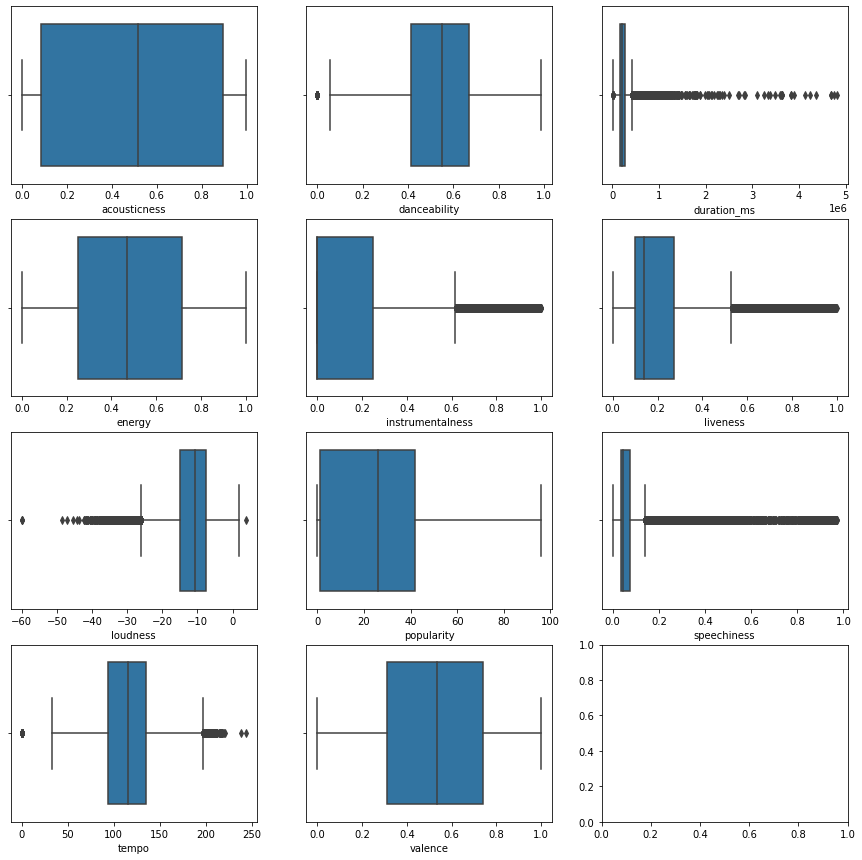

In [19]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))

for feature_name, ax in zip(numerical_features, axes.flatten()):
    sns.boxplot(data[feature_name], ax=ax)

Let us focus on songs that display a close-to-0 `tempo` (number of beats per minute) which seems strange.

In [20]:
len(data[data['tempo'] < 10]), data[data['tempo'] < 10]['tempo'].sum()

(46, 0.0)

46 songs have a `tempo` of 0. This number is very small in comparison with the overall number of songs available and considering the wide distribution of values for this features (it would be a strong to impute the median for instance), we make the simplifying choice of dropping these songs.

In [21]:
data = data[data['tempo'] > 0].copy()

In [22]:
data.shape

(52267, 18)

Finally, we might want to look for duplicates (inspired by weird results when displaying the 46 songs with 0 `tempo`).

In [23]:
data.drop_duplicates().shape

(52007, 18)

Indeed, there is a significant number of duplicates in the dataset! We can eliminate these:

In [24]:
data.drop_duplicates(inplace=True)

Let us control that the `id` is now unique for each observation.

In [25]:
# We check the count on the artist column but we could take any column
data.groupby('id').count()['artist'].max()

1

It seems that we have gone through most data cleaning steps, at least for a first quick process.

### Save your results

Run the following cell to save your results.

In [26]:
from nbresult import ChallengeResult

ChallengeResult(
    "c5_data_cleaning",
    data=data).write()

## Baseline

**📝 We want to use a metric that measures the prediction error in the same unit than `popularity`. In addition, it should strongly penalize largest errors. Which sklearn's [metric](https://scikit-learn.org/stable/modules/model_evaluation.html) should we use? Store its exact name as string below**

We can use the root mean squared error which penalizes the largest errors (because we consider squared errors vs. for instance absolute errors) and outputs a score in the same unit than `popularity` (thanks to the "root").

In [27]:
scoring = "Root Mean Squared Error (RMSE)"

In practice, we will use the `mean_squared_error` metric with `squared=False` from Scikit-Learn.

**📝 Let's build a baseline model using only the numerical features in our dataset.**
- Build `X_baseline` with only numerical features
- Build `y` your target containing the `popularity`
- Then 5 times cross validate the baseline linear model of your choice (do not fine tune it)
- Store your mean performance in a `float` variable named `baseline_score`

- Build `X_baseline` with only numerical features

In [28]:
# We add categorical variables to the list of numerical features as they are already encoded
# (We could consider one-hot encoding key at some point, the determinant would be whether there is an ordering or not)
numerical_features += ['explicit', 'key']

# We drop the target from the X array
X_baseline = data[numerical_features].drop(columns='popularity')

# Let's have a look at the shape of the input
print(X_baseline.shape)

# And at the first 5 rows
X_baseline.head()

(52007, 12)


,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,explicit,key
0,0.65400,0.499,219827,0.190,0.004090,0.0898,-16.435,0.0454,149.460,0.4300,0,7
1,0.00592,0.439,483948,0.808,0.140000,0.0890,-8.497,0.0677,138.040,0.0587,0,2
2,0.73400,0.523,245693,0.288,0.000000,0.0771,-11.506,0.2140,75.869,0.4640,0,0
3,0.42900,0.681,130026,0.165,0.000000,0.3940,-21.457,0.9460,145.333,0.2880,0,11
4,0.56200,0.543,129813,0.575,0.000004,0.1270,-7.374,0.0265,139.272,0.8010,0,2


- Build `y` your target containing the `popularity`

In [31]:
# We build our target that contains popularity
y = data['popularity']

- Then 5 times cross validate the baseline linear model of your choice (do not fine tune it)

In [34]:
# We instantiate a linear regression model
lin_reg = LinearRegression()

# We run the baseline score cross-validation
cv_results = cross_validate(
    lin_reg,   # Our estimator 
    X_baseline, y,   # The baseline data 
    scoring='neg_root_mean_squared_error',   # The scoring method (equivalent to minimizing a positive RMSE)
    cv=5,   # Number of cross-validations
    verbose=1
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished


- Store your mean performance in a `float` variable named `baseline_score`

In [35]:
# We take the opposite to have a positive root mean squared error but it has no real impact
baseline_score = - cv_results['test_score'].mean()

print(baseline_score)

18.349551535391008


### Save your results

Run the following cell to save your results.

In [36]:
from nbresult import ChallengeResult

ChallengeResult(
    "baseline",
    scoring=scoring,
    baseline_score=baseline_score).write()

## Feature engineering

Let's now use the features that we left aside: `release_date` and `artist` to improve the performance of our model. We'll create them manually in a train vs. test context first (and pipeline them later)

### holdout
**📝 Create the 4 variables `X_train` `y_train`, `X_test`, `y_test` with a 50% split with random sampling**

In [37]:
# Compared with X_baseline, we add the song id to make sure the match with year and artist will be correct
if 'id' not in numerical_features:
    numerical_features.append('id')

# We only keep numerical features in the X vector and drop popularity
X = data[numerical_features].drop(columns='popularity')

# We build our target that contains popularity scores
y = data['popularity'].values

# We run the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

In [38]:
# Let us control the shapes of the train set components
X_train.shape, y_train.shape

((26003, 13), (26003,))

In [39]:
# Let us control the shapes of the test set components
X_test.shape, y_test.shape

((26004, 13), (26004,))

In [40]:
# We can have a look at the firs rows of the X_train DataFrame
X_train.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,explicit,key,id
30006,0.871,0.387,29987,0.2680,0.266000,0.1810,-20.438,0.0795,72.473,0.300,0,5,1CijGTc4ke16v4IOFrB5jo
21001,0.954,0.235,181840,0.2060,0.002960,0.1610,-12.131,0.0316,93.913,0.253,0,10,11iZkdNnYuFIHR1Ar0vVKV
1356,0.162,0.496,188173,0.5050,0.832000,0.1040,-9.569,0.0477,127.351,0.196,0,2,7fR7pgBcRGjTYCOJzjnYEc
6534,0.978,0.305,127987,0.0151,0.910000,0.0971,-20.324,0.0401,66.257,0.113,0,3,2kIMeYpRnbkZbK3t93Snia
39860,0.698,0.576,206533,0.4050,0.000041,0.1440,-5.838,0.0491,145.388,0.572,0,4,2UCxVajVSBmExOoUamjtMd


### year

**📝 Create `X_train_year` and `X_test_year` by adding the new column `year` containing the release year of the track as integer**

In [42]:
# We merge X_train and X_test with the two relevant columns of the data DataFrame
# So as to eventually add the year as a feature of the model
X_train_year = X_train.merge(data[['id', 'release_date']], how='left', on='id')
X_test_year = X_test.merge(data[['id', 'release_date']], how='left', on='id')

# We only keep the year from the datetime objects
X_train_year['release_date'] = X_train_year['release_date'].dt.year
X_test_year['release_date'] = X_test_year['release_date'].dt.year

# We rename the column as 'year'
X_train_year.rename(columns={'release_date': 'year'}, inplace=True)
X_test_year.rename(columns={'release_date': 'year'}, inplace=True)

# We can check the first rows of the new X_train_year DataFrame
X_train_year.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,explicit,key,id,year
0,0.871,0.387,29987,0.2680,0.266000,0.1810,-20.438,0.0795,72.473,0.300,0,5,1CijGTc4ke16v4IOFrB5jo,1931
1,0.954,0.235,181840,0.2060,0.002960,0.1610,-12.131,0.0316,93.913,0.253,0,10,11iZkdNnYuFIHR1Ar0vVKV,1948
2,0.162,0.496,188173,0.5050,0.832000,0.1040,-9.569,0.0477,127.351,0.196,0,2,7fR7pgBcRGjTYCOJzjnYEc,1998
3,0.978,0.305,127987,0.0151,0.910000,0.0971,-20.324,0.0401,66.257,0.113,0,3,2kIMeYpRnbkZbK3t93Snia,2018
4,0.698,0.576,206533,0.4050,0.000041,0.1440,-5.838,0.0491,145.388,0.572,0,4,2UCxVajVSBmExOoUamjtMd,1998


In [43]:
# As well as its shape, with the same number of observations and an additional column
X_train_year.shape

(26003, 14)

### artist

How could we use the `artist` column? There are too many artists to one hot encode it.  
We could instead create an `artist_popularity` feature containing the mean popularity of an artist, computed as the mean popularity of all tracks the artist released _on the train set_.

#### Process artist popularity from the Training set

**📝 Compute and store the `artist_popularity` as a new pandas `Series`**  

In [45]:
# We start by adding the popularity column to X_train_year
X_train_year['popularity'] = y_train

# We merge X_train_year with the two relevant columns of the data DataFrame to add artist names
X_train_year = X_train_year.merge(data[['id', 'artist']], on='id', how='left')

# These two steps allow to group the dataset by artist and compute the mean popularity for each of them
artist_popularity = X_train_year.groupby('artist').mean()['popularity']

# We do not forget to eliminate the target from the X_train_year DataFrame
X_train_year.drop(columns='popularity', inplace=True)

# We can have a look at the first rows of the artist_popularity Pandas Series
artist_popularity.head()

artist
"Test for Victor Young"     3.000000
"Weird Al" Yankovic        36.833333
$uicideBoy$                73.000000
*NSYNC                     42.400000
-Sd-                        0.000000
Name: popularity, dtype: float64

#### Apply the artist popularity to `X_train_year`

**📝 Create a new DataFrame `X_train_engineered` which adds a new column to the existing `X_train_year` with the `artist_popularity` corresponding to the song's artist.** 

🚨 Make sure that the target `popularity` does not end up in `X_train_engineered` 

In [46]:
# We reset the index of the artist_popularity Series to get a 2D object (a DataFrame)
artist_popularity = artist_popularity.reset_index()

# We merge X_train_year with the new artist_popularity DataFrame on artists' name
# This allows to add a new column to the train set DataFrame with the artists' mean popularity
# And we drop both id and artist columns
X_train_engineered = X_train_year.merge(artist_popularity, on='artist', how='left').drop(columns=['artist', 'id'])

# We check the shape of the resulting DataFrame 
X_train_engineered.shape

(26003, 14)

In [47]:
X_train_engineered.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,explicit,key,year,popularity
0,0.871,0.387,29987,0.2680,0.266000,0.1810,-20.438,0.0795,72.473,0.300,0,5,1931,0.000000
1,0.954,0.235,181840,0.2060,0.002960,0.1610,-12.131,0.0316,93.913,0.253,0,10,1948,0.000000
2,0.162,0.496,188173,0.5050,0.832000,0.1040,-9.569,0.0477,127.351,0.196,0,2,1998,46.666667
3,0.978,0.305,127987,0.0151,0.910000,0.0971,-20.324,0.0401,66.257,0.113,0,3,2018,0.000000
4,0.698,0.576,206533,0.4050,0.000041,0.1440,-5.838,0.0491,145.388,0.572,0,4,1998,39.400000


#### Apply the artist popularity to `X_test_year`

**📝 Similarily, create a new DataFrame `X_test_engineered` which also adds a new column to the existing `X_test_year` with the `artist_popularity` corresponding to the song's artist, computed from the training set.**

🚨**If an artist has never been seen in the training set, use the global mean popularity of all the tracks of `X_train`**

In [48]:
# We store and print the global mean popularity of all tracks in X_train
global_mean_popularity = y_train.mean()

print(global_mean_popularity)

25.848555935853554


In [53]:
# We add a column containing artist names to X_test_year (thanks to the global dataset, data)
X_test_engineered = X_test_year.merge(data[['id', 'artist']], on='id', how='left')

# We add the mean popularity of the artists that are also in the train set
# By merging the artist_popularity DataFrame
X_test_engineered = X_test_engineered.merge(artist_popularity, on='artist', how='left')

# We drop both id and artist columns
X_test_engineered.drop(columns=['id', 'artist'], inplace=True)

# We can have a look at the shape of the resulting DataFrame
print(X_test_engineered.shape)

X_test_engineered.head()

(26004, 14)


,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,explicit,key,year,popularity
0,0.91600,0.152,193173,0.208,0.000113,0.0998,-13.983,0.0354,80.211,0.148,0,0,1956,24.855769
1,0.05660,0.526,267212,0.655,0.000000,0.1160,-4.208,0.3260,121.127,0.156,1,1,2015,NaN
2,0.00221,0.483,146907,0.573,0.000031,0.0674,-7.951,0.0286,102.122,0.506,0,7,1968,37.548387
3,0.62500,0.463,267400,0.338,0.000011,0.0943,-13.117,0.0329,148.451,0.269,0,2,1984,NaN
4,0.93500,0.451,174080,0.334,0.930000,0.1260,-15.190,0.0321,110.016,0.147,0,3,1946,1.666667


As mentioned in the comments, we have added a column that contains the mean popularity of the artist, but this is true only for the songs that were done by an artist that can be found in the train dataset ! Indeed:

In [54]:
X_test_engineered.isnull().sum()

acousticness           0
danceability           0
duration_ms            0
energy                 0
instrumentalness       0
liveness               0
loudness               0
speechiness            0
tempo                  0
valence                0
explicit               0
key                    0
year                   0
popularity          4914
dtype: int64

For 4914 observations of the test set (this number can vary as the train-test split is random), the artist could not be found in `artist_popularity` and we therefore need to impute a value to replace these NaNs. We use to do so the `global_mean_popularity` which we have computed earlier.

In [55]:
X_test_engineered['popularity'] = X_test_engineered['popularity'].fillna(global_mean_popularity)

In [56]:
# We rename the popularity columns for a more explicit name
X_train_engineered.rename(columns={'popularity': 'artist_popularity'}, inplace=True)
X_test_engineered.rename(columns={'popularity': 'artist_popularity'}, inplace=True)

In [58]:
# We can print the shapes to control
print(X_train_engineered.shape, y_train.shape)
print(X_test_engineered.shape, y_test.shape)

(26003, 14) (26003,)
(26004, 14) (26004,)


### Save your results

Run the following cell to save your results.

In [59]:
from nbresult import ChallengeResult

_ = pd.concat([X_train_engineered, X_test_engineered])

ChallengeResult("c7_feature_engineering",
    shape = _.shape,
    cols = _.columns,
    years = _.get("year"),
    popularities = _.get("artist_popularity"),
).write()

### Performance

**📝 Let's see how these features impact the performance of our model. Retrain the same baseline model on numerical values only, but adding the new features `year` and `artist_popularity`, and see how the performance is impacted. Save the performance in a `float` variable named `score_engineered`**

👉 Do not fine tune the model yet

In [60]:
# We instantiate the model
lin_reg = LinearRegression()

# We fit on our new train set 
lin_reg.fit(X_train_engineered, y_train)

# We save its predictions on the test set in a specific variable
y_pred = lin_reg.predict(X_test_engineered)

# And we compute the related root mean squared error
score_engineered = mean_squared_error(y_test, y_pred, squared=False)

print(score_engineered)

14.299067752054091


Sure, it is not worth a cross-validated score as our baseline score was but we have made significant progress with these new features!

In [62]:
# As a reminder
baseline_score

18.349551535391008

### Save your results

Run the following cell to save your results.

In [46]:
from nbresult import ChallengeResult

ChallengeResult(
    "c7_score_engineering",
    scoring=scoring,
    score_engineered=score_engineered).write()

## Pipelining

**📝 Let's create a full sklearn preprocessing pipeline called `preproc`. It should integrate our feature engineering for `year` and `artist_popularity`, as well as any other preprocessing of your choice**

**Store also the number of columns/feature after preprocessing your inputs in a variable `col_number`**

**🚨⚠️ Advice: SKIP the `ArtistPopularityTransformer` if you don't have time to do it. It is better for you to have a working pipeline rather than NO pipeline at all**

In [63]:
# 👉 Do not hesitate to reload clean new dataset if you need a fresh start
data = pd.read_csv(url)

# We drop missing values and 0-tempo observations as before 
# (Not included in the pipeline as this affects both the X and the y)
data.dropna(inplace=True)
data = data[data['tempo'] > 0].copy()

# We get the DataFrame containing explanatory variables and the target vector
y = data.popularity
X = data.drop("popularity", axis=1)

In [64]:
# We run a train-test split similar to the one done above
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

In [65]:
# Run this cell to visualize your pipeline as you build it
from sklearn import set_config; set_config(display='diagram')

In [66]:
# We give you below the skeleton of the custom ArtistPopularityTransformer to complete

from sklearn.base import BaseEstimator, TransformerMixin

class ArtistPopularityTransformer(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass

    def fit(self, X, y=None):
        """
        process artist mean popularity from artists songs popularity
        process song global mean popularity
        """
        # We need the popularity of the songs to compute each artist's mean popularity
        if y is None:
            # Which is why this check is required
            raise Exception("We need the y vector to compute artists' average popularity.")
        
        # We start by making a copy of the DataFrame
        X = X.copy()
        
        # As before we temporarily add a column popularity to the X DataFrame
        X['popularity'] = y
        
        # We compute each artist's average popularity by grouping the dataset
        self.artist_popularity = X.groupby('artist').mean()['popularity']
        
        # We also save as an attribute of the transformer the global mean popularity of all songs in the train set
        self.global_mean_popularity = y.mean()
        
        return self

    def transform(self, X, y=None):
        """
        apply artist mean popularity vs song global mean popularity to songs
        """

        # We start by making a copy of the DataFrame
        X = X.copy()
        
        # This function associates to each artist either his/her mean popularity if it is present in the train set
        # Or the global mean popularity of all songs in the train set if it is a "new" artist
        # We map the function on the artist column replacing the artist name by the output of the function
        X['artist'] = X['artist'].map(
            lambda artist: self.artist_popularity.loc[artist] if artist in self.artist_popularity.index else self.global_mean_popularity
        )
        
        # We return a copy of the modified DataFrame 
        return X.copy()
        
    
class ReleaseYearTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    # By convention
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        # We copy the DataFrame
        X = X.copy()
        
        # We change the format of the release_date column to datetime
        X['release_date'] = pd.to_datetime(X['release_date'])
        
        # We only keep the years as integers
        X['release_date'] = X['release_date'].dt.year
        
        # We return the resulting DataFrame
        return X.copy()

We also want to take advantage of this preprocessing pipeline to scale the features in the dataset. We will either use a simple `MinMaxScaler` or a `RobustScaler` depending on the presence or not of outliers, which we identify thanks to the following boxplots.

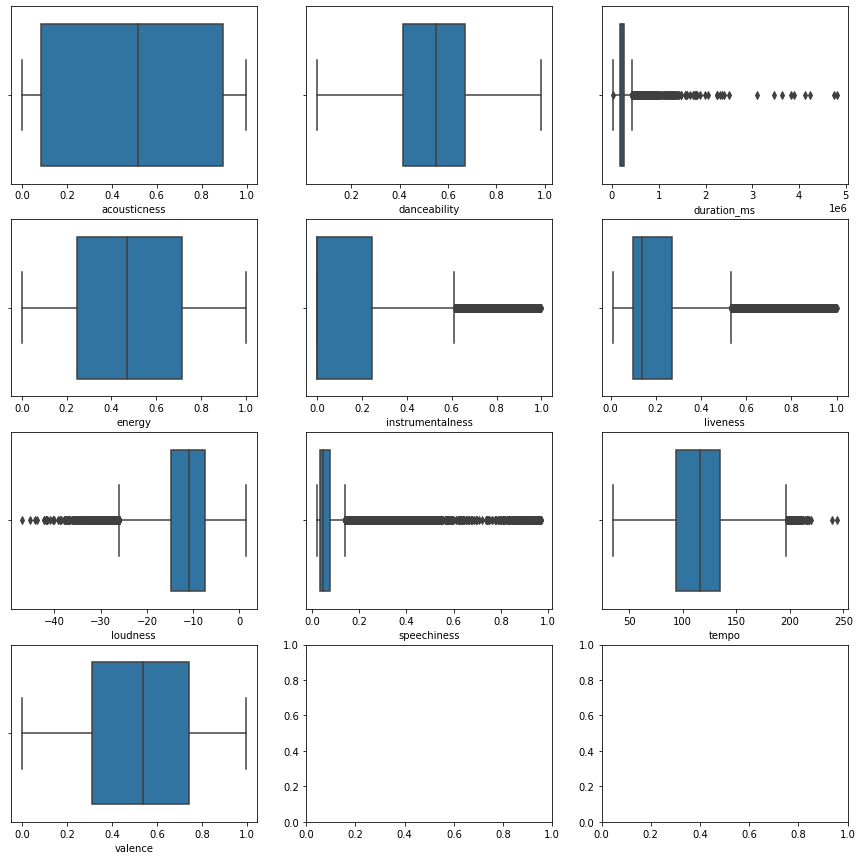

In [67]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))

features_to_plot = numerical_features[:-3]
features_to_plot.remove('popularity')

for feature_name, ax in zip(features_to_plot, axes.flatten()):
    sns.boxplot(X_train[feature_name], ax=ax)

In [68]:
# This transformer will contain all the column-per-column transformations
ct = ColumnTransformer(
    transformers=[
        # Dropping columns that will not be used by the model
        ('drop_id_and_song_name', 'drop', ['id', 'name']),
        
        # Scaling continuous features that do not display outliers
        ('min_max_scaler', MinMaxScaler(), ['duration_ms', 'acousticness', 'danceability', 'energy', 'valence']),

        # Scaling continuous features that display outliers
        ('robust_scaler', RobustScaler(), ['instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo']),
        
        # One-hot encoding the multi-categorical key variable 
        ('key_encoding', OneHotEncoder(), ['key']),
        
        # Transforming the date column with the custom transformers
        ('release_year', ReleaseYearTransformer(), ['release_date'])
    ],
    # Binary variables and mean artist popularity are not modified
    remainder='passthrough'
)

In [69]:
# We now move to a pipeline to chain the custom transformer relative to the artist column with the ColumnTransformer
preproc = Pipeline(
    steps=[
        # First applying the transformation relative to the artist colum
        ('artist_popularity', ArtistPopularityTransformer()),
        
        # Applying the column transformer
        ('scaling_and_additional_preprocessing', ct)
    ]
)

In [70]:
# We fit the pipeline on the train set
preproc.fit(X_train, y_train)

Pipeline(steps=[('artist_popularity', ArtistPopularityTransformer()),
                ('scaling_and_additional_preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('drop_id_and_song_name',
                                                  'drop', ['id', 'name']),
                                                 ('min_max_scaler',
                                                  MinMaxScaler(),
                                                  ['duration_ms',
                                                   'acousticness',
                                                   'danceability', 'energy',
                                                   'valence']),
                                                 ('robust_scaler',
                                                  RobustScaler(),
                                                  ['instrumentalness',
                                                   'liveness', 'loudness',
                                                   'speechiness', 'tempo']),
                                                 ('key_encoding',
                                                  OneHotEncoder(), ['key']),
                                                 ('release_year',
                                                  ReleaseYearTransformer(),
                                                  ['release_date'])]))])

In [71]:
# And we can have a look at the first row of its output for the train set
pd.DataFrame(preproc.transform(X_train)).head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,0.038375,0.975904,0.367978,0.175158,0.240201,2.144976,0.945790,-0.742602,0.067470,0.030948,...,0.0,0.0,0.0,0.0,0.0,0.0,1932.0,0.0,1.0,5.0000
1,0.039882,0.000808,0.372299,0.798795,0.455276,0.002322,-0.425606,-0.147818,0.831325,-0.368416,...,0.0,0.0,0.0,0.0,0.0,0.0,1980.0,0.0,0.0,36.5000
2,0.036154,0.998996,0.694252,0.080862,0.819095,0.037057,-0.098039,-0.048372,3.715663,-0.397568,...,0.0,0.0,0.0,0.0,0.0,0.0,1944.0,0.0,1.0,0.0000
3,0.046369,0.160642,0.580812,0.820817,0.081206,0.908241,0.582468,0.951898,0.156627,1.321642,...,0.0,0.0,0.0,0.0,0.0,0.0,2021.0,0.0,0.0,0.0000
4,0.047079,0.007188,0.631590,0.771767,0.775879,-0.000959,0.761246,0.938116,0.077108,0.293485,...,0.0,0.0,0.0,1.0,0.0,0.0,1981.0,0.0,1.0,34.8125


In [72]:
# We store in a dedicated variable the number of columns in the output of the pipeline
col_number = pd.DataFrame(preproc.transform(X_train)).shape[1]
print(col_number)

26


#### Save your results

Run the following cell to save your results.

In [73]:
# Print below your preproc here for the correctors
from sklearn import set_config; set_config(display='diagram')
preproc

Pipeline(steps=[('artist_popularity', ArtistPopularityTransformer()),
                ('scaling_and_additional_preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('drop_id_and_song_name',
                                                  'drop', ['id', 'name']),
                                                 ('min_max_scaler',
                                                  MinMaxScaler(),
                                                  ['duration_ms',
                                                   'acousticness',
                                                   'danceability', 'energy',
                                                   'valence']),
                                                 ('robust_scaler',
                                                  RobustScaler(),
                                                  ['instrumentalness',
                                                   'liveness', 'loudness',
                                                   'speechiness', 'tempo']),
                                                 ('key_encoding',
                                                  OneHotEncoder(), ['key']),
                                                 ('release_year',
                                                  ReleaseYearTransformer(),
                                                  ['release_date'])]))])

In [74]:
from nbresult import ChallengeResult

ChallengeResult(
    "c6_preprocessing",
    col_number=col_number
).write()

## Training

📝 Time to optimize 

- **Add an estimator to your pipeline (only from scikit-learn)** 

- **Train your pipeline and fine-tune (optimize) your estimator to get the best prediction score**

- **You must create 2 pipelines (one with a linear model, one with an ensemble model)**

Then, 

- Save your two best 5-time cross-validated scores as _float_: `score_linear` and `score_ensemble`

- Save your two best trained pipelines as _Pipeline_ objects: `pipe_linear` and `pipe_ensemble`

### Linear

In [75]:
# We recreate the previous pipeline adding a lasso model at the last step
linear_pipeline = Pipeline(
    steps=[
        ('artist_popularity', ArtistPopularityTransformer()),
        ('scaling_and_additional_preprocessing', ct),
        ('linear_model', Lasso())
    ]
)

In [76]:
# We try a first fit on the train set
linear_pipeline.fit(X_train, y_train)

Pipeline(steps=[('artist_popularity', ArtistPopularityTransformer()),
                ('scaling_and_additional_preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('drop_id_and_song_name',
                                                  'drop', ['id', 'name']),
                                                 ('min_max_scaler',
                                                  MinMaxScaler(),
                                                  ['duration_ms',
                                                   'acousticness',
                                                   'danceability', 'energy',
                                                   'valence']),
                                                 ('robust_scaler',
                                                  RobustScaler(),
                                                  ['instrumentalness',
                                                   'liveness', 'loudness',
                                                   'speechiness', 'tempo']),
                                                 ('key_encoding',
                                                  OneHotEncoder(), ['key']),
                                                 ('release_year',
                                                  ReleaseYearTransformer(),
                                                  ['release_date'])])),
                ('linear_model', Lasso())])

In [77]:
# We store predictions 
y_pred = linear_pipeline.predict(X_test)

# We compute the resulting root mean squared error
rmse_linear_not_tuned = mean_squared_error(y_test, y_pred, squared=False)

# And we print it (it is closed to the previous result without tuning)
print(rmse_linear_not_tuned)

14.296878872265875


In [79]:
# This dictionary stores the hyperparameter values that we want to test in our GridSearch
param_grid = {
    'linear_model__alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2]
}

In [80]:
# We re-instantiate a clean pipeline
linear_pipeline = Pipeline(
    steps=[
        ('artist_popularity', ArtistPopularityTransformer()),
        ('scaling_and_additional_preprocessing', ct),
        ('linear_model', Lasso())
    ]
)

# And we construct the grid search
grid_search = GridSearchCV(
    linear_pipeline,   # Our estimator
    param_grid=param_grid,   # The hyperparameters to test
    scoring='neg_root_mean_squared_error',   # Scoring with the root mean squared error
    cv=5,   # Number of cross-validations
    verbose=1,
    refit=True,   # Will re-fit the best-performing model on the whole dataset 
    n_jobs=-1
)

In [81]:
%%time

# We fit the grid search on the train set
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   15.9s finished


CPU times: user 2.37 s, sys: 291 ms, total: 2.66 s
Wall time: 16.5 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('artist_popularity',
                                        ArtistPopularityTransformer()),
                                       ('scaling_and_additional_preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('drop_id_and_song_name',
                                                                         'drop',
                                                                         ['id',
                                                                          'name']),
                                                                        ('min_max_scaler',
                                                                         MinMaxScaler(),
                                                                         ['duration_ms',
                                                                          'acousticness',
                                                                          'danceability',
                                                                          'energy',
                                                                          'valence']),
                                                                        ('robust_scaler',
                                                                         RobustScaler(),
                                                                         ['instrumentalness',
                                                                          'liveness',
                                                                          'loudness',
                                                                          'speechiness',
                                                                          'tempo']),
                                                                        ('key_encoding',
                                                                         OneHotEncoder(),
                                                                         ['key']),
                                                                        ('release_year',
                                                                         ReleaseYearTransformer(),
                                                                         ['release_date'])])),
                                       ('linear_model', Lasso())]),
             n_jobs=-1,
             param_grid={'linear_model__alpha': [0.001, 0.005, 0.01, 0.05, 0.1,
                                                 0.5, 1, 2]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [82]:
# We can have a look at selected hyperparameters
grid_search.best_params_

{'linear_model__alpha': 0.001}

In [83]:
# At the smallest cross-validated root mean squared error obtained
- grid_search.best_score_

14.676697986625793

In [84]:
# We run predictions with the best model re-fit on the whole train set
y_pred = grid_search.best_estimator_.predict(X_test)

# We store the resulting RMSE
rmse_linear_tuned = mean_squared_error(y_test, y_pred, squared=False)

print(rmse_linear_not_tuned)

14.296878872265875


The performance increment provided by the hyperparameter tuning is not really significant.

### Ensemble

**NB:** XGBRegressor is not a Scikit-Learn model as mentioned in the question but the class follows the same syntax as a Scikit-Learn estimator.

In [85]:
# We recreate the previous pipeline adding an XGBosst regressor at the last step
ensemble_pipeline = Pipeline(
    steps=[
        ('artist_popularity', ArtistPopularityTransformer()),
        ('scaling_and_additional_preprocessing', ct),
        ('ensemble_model', XGBRegressor())
    ]
)

In [86]:
# We fit a first, non-tuned pipeline on the train set
ensemble_pipeline.fit(X_train, y_train)

Pipeline(steps=[('artist_popularity', ArtistPopularityTransformer()),
                ('scaling_and_additional_preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('drop_id_and_song_name',
                                                  'drop', ['id', 'name']),
                                                 ('min_max_scaler',
                                                  MinMaxScaler(),
                                                  ['duration_ms',
                                                   'acousticness',
                                                   'danceability', 'energy',
                                                   'valence']),
                                                 ('robust_scaler',
                                                  RobustScaler(),
                                                  ['instru...
                              colsample_bytree=1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='',
                              learning_rate=0.300000012, max_delta_step=0,
                              max_depth=6, min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=100,
                              n_jobs=0, num_parallel_tree=1, random_state=0,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                              subsample=1, tree_method='exact',
                              validate_parameters=1, verbosity=None))])

In [87]:
# We run predictions on the test set
y_pred = ensemble_pipeline.predict(X_test)

# And we store the resulting RMSE
rmse_ensemble_not_tuned = mean_squared_error(y_test, y_pred, squared=False)

print(rmse_ensemble_not_tuned)

12.790340610471395


The performance increment from the lasso model seems significant although we do not consider a cross-validated score here!

In [88]:
# Hyperparameters to test in the randomized search
param_distributions = {
    'ensemble_model__n_estimators': randint(50, 150),
    'ensemble_model__max_depth': randint(5, 25),
    'ensemble_model__learning_rate': uniform(0.05, 0.3),
    'ensemble_model__min_child_weight': randint(1, 7),
    'ensemble_model__gamma': uniform(0, 0.5),
    'ensemble_model__reg_alpha': [1e-5, 1e-2, 0.1, 1, 100],
    'ensemble_model__booster': ['gbtree', 'gblinear', 'dart']
}

In [138]:
# Re-instantiating a clean pipeline
ensemble_pipeline = Pipeline(
    steps=[
        ('artist_popularity', ArtistPopularityTransformer()),
        ('scaling_and_additional_preprocessing', ct),
        ('ensemble_model', XGBRegressor())
    ]
)

# Instantiating the randomized search
random_search = RandomizedSearchCV(
    ensemble_pipeline, 
    param_distributions=param_distributions,
    n_iter=30,
    scoring='neg_root_mean_squared_error',
    cv=5, 
    verbose=1,
    refit=True , 
    n_jobs=-1
)

**NB:** As expected (and as can be seen) the following cell was taking a bit of time, so I did not rerun a second time. The same goes for the following cells. So, these results were not obtained with the same train-test split as those above. 

In [139]:
%%time

# We fit the randomized search on the train set
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 19.5min finished


CPU times: user 37.2 s, sys: 1.14 s, total: 38.3 s
Wall time: 19min 38s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('artist_popularity',
                                              ArtistPopularityTransformer()),
                                             ('scaling_and_additional_preprocessing',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('drop_id_and_song_name',
                                                                               'drop',
                                                                               ['id',
                                                                                'name']),
                                                                              ('min_max_scaler',
                                                                               MinMaxScaler(),
                                                                               ['duration_ms',
                                                                                'acousticness',
                                                                                'danceability',
                                                                                'energy',
                                                                                'valence']),
                                                                              ('robu...
                                        'ensemble_model__max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x131f44d10>,
                                        'ensemble_model__min_child_weight': <scipy.stats._distn_infrastructure.rv_frozen object at 0x131f46210>,
                                        'ensemble_model__n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x131f44c50>,
                                        'ensemble_model__reg_alpha': [1e-05,
                                                                      0.01, 0.1,
                                                                      1, 100]},
                   scoring='neg_root_mean_squared_error', verbose=1)

In [143]:
# We can check the best-performing combination of hyperparameters
random_search.best_params_

{'ensemble_model__booster': 'gbtree',
 'ensemble_model__gamma': 0.3364093010602823,
 'ensemble_model__learning_rate': 0.12423312668551885,
 'ensemble_model__max_depth': 14,
 'ensemble_model__min_child_weight': 6,
 'ensemble_model__n_estimators': 110,
 'ensemble_model__reg_alpha': 100}

In [144]:
# We can also look at the best cross-validated RMSE
- random_search.best_score_

13.202002312127174

In [145]:
# Running predictions on the test set
y_pred = random_search.best_estimator_.predict(X_test)

# Storing the resulting RMSE
rmse_ensemble_tuned = mean_squared_error(y_test, y_pred, squared=False)

print(rmse_ensemble_tuned)

12.682370740213036


### Save your results

Run the following cell to save your results.

In [146]:
# We store the best-performing pipelines
pipe_linear = grid_search.best_estimator_
pipe_ensemble = random_search.best_estimator_

In [147]:
# We rename the variables storing our test set results
score_linear = rmse_linear_tuned
score_ensemble = rmse_ensemble_tuned

In [148]:
# Print below your best pipe for correction purpose
from sklearn import set_config; set_config(display='diagram')
pipe_linear

Pipeline(steps=[('artist_popularity', ArtistPopularityTransformer()),
                ('scaling_and_additional_preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('drop_id_and_song_name',
                                                  'drop', ['id', 'name']),
                                                 ('min_max_scaler',
                                                  MinMaxScaler(),
                                                  ['duration_ms',
                                                   'acousticness',
                                                   'danceability', 'energy',
                                                   'valence']),
                                                 ('robust_scaler',
                                                  RobustScaler(),
                                                  ['instrumentalness',
                                                   'liveness', 'loudness',
                                                   'speechiness', 'tempo']),
                                                 ('key_encoding',
                                                  OneHotEncoder(), ['key']),
                                                 ('release_year',
                                                  ReleaseYearTransformer(),
                                                  ['release_date'])])),
                ('linear_model', Lasso(alpha=0.001))])

In [149]:
# Print below your best pipe for correction purpose
pipe_ensemble

Pipeline(steps=[('artist_popularity', ArtistPopularityTransformer()),
                ('scaling_and_additional_preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('drop_id_and_song_name',
                                                  'drop', ['id', 'name']),
                                                 ('min_max_scaler',
                                                  MinMaxScaler(),
                                                  ['duration_ms',
                                                   'acousticness',
                                                   'danceability', 'energy',
                                                   'valence']),
                                                 ('robust_scaler',
                                                  RobustScaler(),
                                                  ['instru...
                              gpu_id=-1, importance_type='gain',
                              interaction_constraints='',
                              learning_rate=0.12423312668551885,
                              max_delta_step=0, max_depth=14,
                              min_child_weight=6, missing=nan,
                              monotone_constraints='()', n_estimators=110,
                              n_jobs=0, num_parallel_tree=1, random_state=0,
                              reg_alpha=100, reg_lambda=1, scale_pos_weight=1,
                              subsample=1, tree_method='exact',
                              validate_parameters=1, verbosity=None))])

In [150]:
from nbresult import ChallengeResult

ChallengeResult("c8_c9_c11_c13_model_tuning",
    scoring = scoring,
    score_linear=score_linear,
    score_ensemble=score_ensemble).write()

## API 

Time to put a pipeline in production!

👉 Go to https://github.com/lewagon/data-certification-api and follow instructions

**This final part is independent from the above notebook**